# PiD Machine learning project

The chosen dataset https://www.kaggle.com/code/marianna13/starter-particle-identification-from-94dec2e4-9/input?select=pid-5M.csv is a GEANT4 simulated dataset of electron proton inelastic scattering containing data for protons, positrons, kaons and pions, let's have a look.

In [1]:
import sys, os
import pandas as pd
import numpy as np
import warnings
import gzip, io, requests
import time
from sklearn.metrics import accuracy_score


nRowsRead = 5000000
filename="datasets/pid-5M.csv"
complete_dataset=pd.read_csv(filename, nrows = nRowsRead)
#complete_dataset=pd.read_csv(filename)

print("The dataset contains:  " + str(complete_dataset.shape[0]) + " rows and " + str(complete_dataset.shape[1]) + " columns" )
complete_dataset.head()

The dataset contains:  5000000 rows and 7 columns


,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


The first column is the label which we want to predict using our models. We have:
- Positron: -11
- Pion: 211
- Kaon: 321
- Proton: 2212

The rest of the dataset resembles data coming from a particle detector, so we have:
- The momentum P (GeV/c), 
- The angle with respect to the beam direction theta (radiant), 
- The factor \beta, 
- The number of photoelectron emitted,
- The energy deposited in the inner and outer region of the detector.

Let's check the correlation matrix then decide which features we should keep.

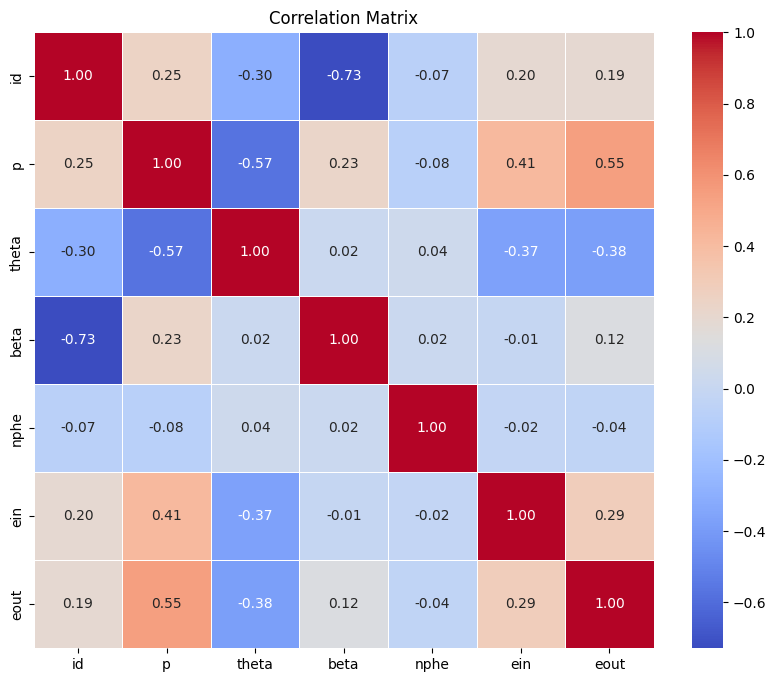

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = complete_dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [3]:
nFeatures = 5
nLabels = 4
#complete_dataset.drop(complete_dataset.columns[4-nFeatures:], axis=1, inplace=True)
complete_dataset.drop(["nphe"], axis=1, inplace=True)
print("The dataset now contains:  " + str(complete_dataset.shape[0]) + " rows and " + str(complete_dataset.shape[1]) + " columns" )
complete_dataset.head()


The dataset now contains:  5000000 rows and 6 columns


,id,p,theta,beta,ein,eout
0,211,0.780041,1.081480,0.989962,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0.034379,0.049256


Now we are interested to see how many particles of each kind are in the dataset and make sure to divide train and test sets accordingly.

In [4]:
N_Test = 9000
N_Train = nRowsRead - N_Test

train_df = complete_dataset.iloc[:N_Train]

# Create Test dataset with the remaining rows
test_df = complete_dataset.iloc[N_Train:]

# Optionally, you can reset the index for both datasets
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("The train dataset contains:  " + str(train_df.shape[0]) + " rows and " + str(train_df.shape[1]) + " columns" )
train_df.head()

#print("The test dataset contains:  " + str(test_df.shape[0]) + " rows and " + str(test_df.shape[1]) + " columns" )
#test_df.head()


The train dataset contains:  4991000 rows and 6 columns


,id,p,theta,beta,ein,eout
0,211,0.780041,1.081480,0.989962,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0.034379,0.049256


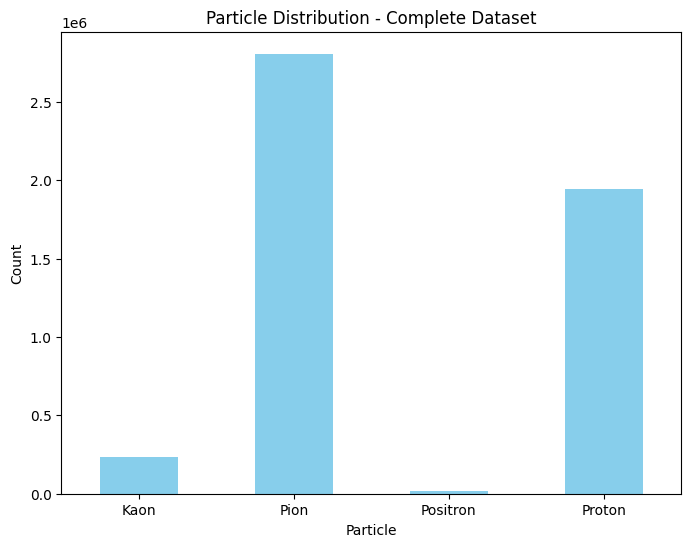

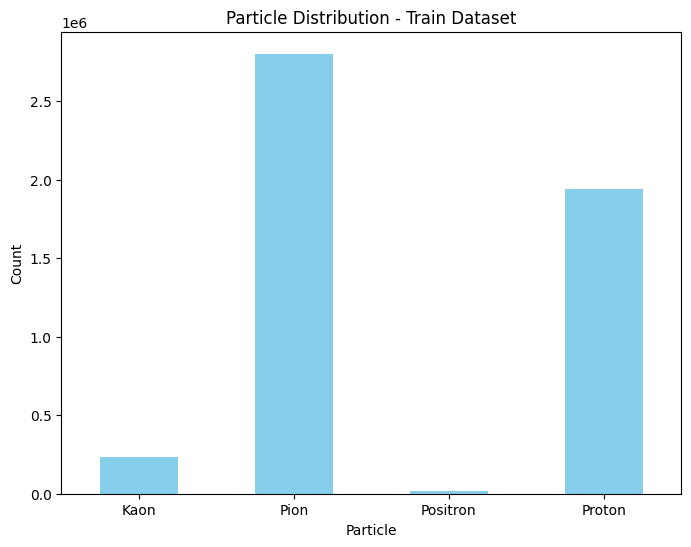

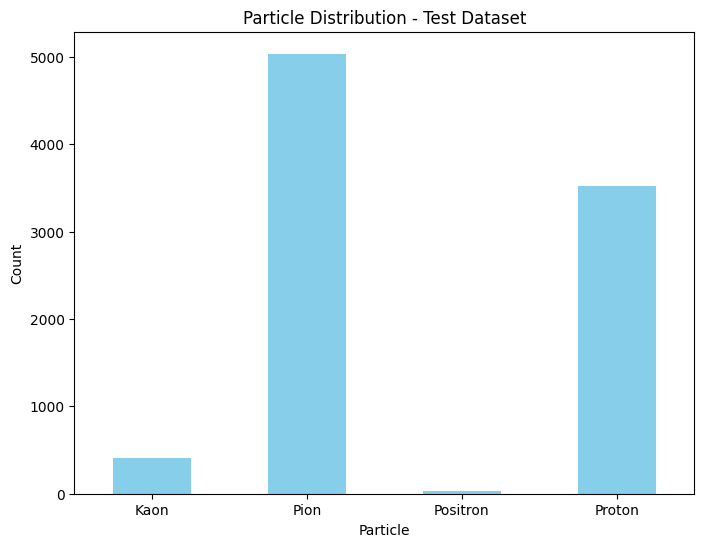

In [5]:

# Define particle ID labels
particle_labels = {
    -11: 'Positron',
    211: 'Pion',
    321: 'Kaon',
    2212: 'Proton'
}

# Function to plot histogram
def plot_histogram(data, title):
    plt.figure(figsize=(8, 6))
    data.value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Particle')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

# Plot histogram for complete dataset
plot_histogram(complete_dataset['id'].map(particle_labels), 'Particle Distribution - Complete Dataset')

# Plot histogram for train dataset
plot_histogram(train_df['id'].map(particle_labels), 'Particle Distribution - Train Dataset')

# Plot histogram for test dataset
plot_histogram(test_df['id'].map(particle_labels), 'Particle Distribution - Test Dataset')





It's a very imbalaced dataset.

Let's fix it using oversample or undersample.

In [6]:
kaons_df = train_df[train_df['id'] == 321]
pions_df = train_df[train_df['id'] == 211]
positrons_df = train_df[train_df['id'] == -11]
protons_df = train_df[train_df['id'] == 2212]
#print(train_df['id'] == -11)
print((train_df['id'] == -11).sum())
print(len(positrons_df))

14820
14820


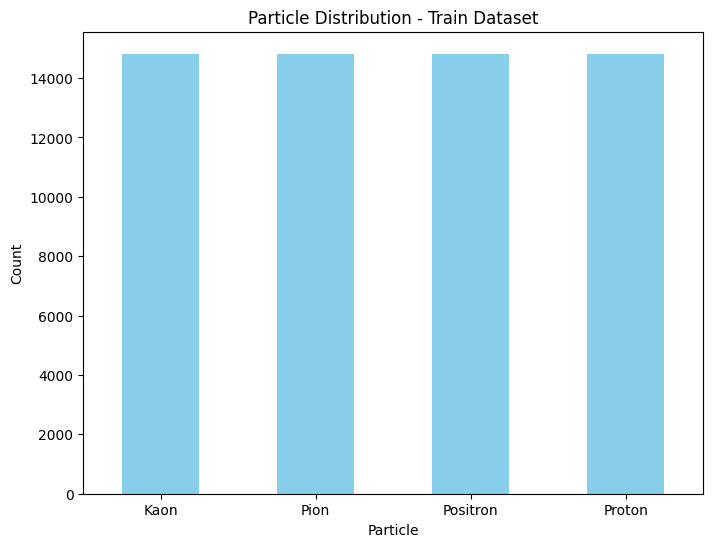

In [7]:
from sklearn.utils import resample

# First divide in classes
kaons_df = train_df[train_df['id'] == 321]
pions_df = train_df[train_df['id'] == 211]
positrons_df = train_df[train_df['id'] == -11]
protons_df = train_df[train_df['id'] == 2212]
#print((train_df['id'] == -11).sum())
#print((train_df['id'] == 211).sum())
#print(positrons_df)

# Now try to oversample Kaons and Positrons, while undesampling Pions and Protons
sample_target = round(len(positrons_df))
#print(len(positrons_df))
kaons_df = kaons_df.sample(sample_target, replace=True if sample_target > len(kaons_df) else False)
pions_df = pions_df.sample(sample_target, replace=True if sample_target > len(pions_df) else False)
positrons_df = positrons_df.sample(sample_target, replace=True if sample_target > len(positrons_df) else False)
protons_df = protons_df.sample(sample_target, replace=True if sample_target > len(protons_df) else False)

train_df = pd.concat([kaons_df, pions_df, positrons_df, protons_df], axis=0)
train_df.head()
plot_histogram(train_df['id'].map(particle_labels), 'Particle Distribution - Train Dataset')

# plt.hist(train_df['nphe'], bins=train_df['nphe'].max() + 5, color='skyblue')
# # Add labels and title
# plt.xlim(-5, train_df['nphe'].max())
# plt.xlabel('Values')
# plt.ylabel('Counts')
# plt.title('Nphe distribution')
# plt.yscale('log')
# # Show the plot
# plt.show()
# print(train_df['nphe'].max() + 0)
# #print(len(train_df), train_df['nphe'].value_counts().get(5, 0))


Now the dataset looks well balanced!

Finally, it is appropriate to shuffle the dataframe as this avoids introducing any bias.

In [8]:
train_df = train_df.sample(frac=1, random_state=34)
train_df.head()
print(len(train_df))


59280


Now we store the features and the labels in different arrays. It is also useful to make a dictionary to easily change between particle IDs and integers if needed as index.

In [9]:
features_array = train_df.iloc[:, -nFeatures:].values
IDs_array = train_df.iloc[:,0].values
features_and_IDs = train_df.iloc[:, -nLabels:].values

test_features_array = test_df.iloc[:, -nFeatures:].values
test_IDs_array = test_df.iloc[:,0].values

particleIDs_index = {
    # This choice follows the plots above
    -11: 2,   # Positron
    211: 1,   # Pion
    321: 0,   # Kaon
    2212: 3   # Proton
}

# Useful for later
IDs_indeces = (train_df["id"].map(particleIDs_index)).values
test_IDs_indeces = (test_df["id"].map(particleIDs_index)).values
num_samples = features_array.shape[0]

#print(IDs_indeces)
#print(len(IDs_indeces))
#print(len(IDs_indeces.dropna().index))

def print_class_accuracy(predicted_class, IDs_indeces):
    # Get the unique classes
    unique_classes = np.unique(IDs_indeces)

    # Iterate over each class and calculate accuracy
    for class_label in unique_classes:
        # Calculate accuracy for the current class
        particle_id = next(key for key, value in particleIDs_index.items() if value == class_label)
        
        class_accuracy = np.mean(predicted_class[IDs_indeces == class_label] == class_label)
        # Print the accuracy for the current class
        print('Accuracy for {}: {:.2f}'.format(particle_labels[particle_id], class_accuracy))

        #print(particle_id)
        #print("IDs_indeces:", IDs_indeces, " Class label: ", class_label)
        #print("class label: ", class_label, "particle_labels:", particle_labels[particle_id])





# First approach: Linear Model

Here we follow the same steps saw during lesson.

Let's start by defining the linear model as follows:


 ${\rm z}_j = X_{i} W_{ij}+b_{j}$

 where, $i=1,2,3$ (i.e. the three features), $j=1,2,3,4$ (Kaon, Pion, Positron, Proton). The probability of this score is given using the sigmoid function:

   $\sigma(z_j) = \frac{\exp(-z_j)}{\sum_k \exp(-z_k)}$
  
repeated indices are understood to be summed over. By definition,

  $\sum_j \sigma(z_j) = 1$
  
so $P(X) = \sigma(z(X))$ outputs 4 values (4 particles) between 0 and 1 that sum to 1.

The final prediction of the model would be the most likely of the possible particle:

${\rm Particle}_{\rm pred} = {\rm argmax}(z(X))$

which is its particle ID:
- Positron: -11
- Pion: 211
- Kaon: 321
- Proton: 2212

Now it's time to initialize and train the model.


Let's first start with gradient descent method.

In [10]:
from IPython.display import display, clear_output
%matplotlib inline

iteration 8400: loss 0.904282


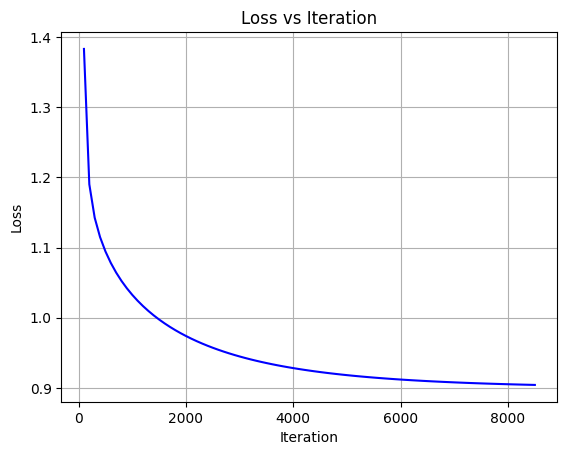

In [44]:

# initialize parameters randomly
W = 0.01 * np.random.randn(nFeatures,nLabels)
#print(W)
b = np.zeros((1,nLabels))

num_samples = features_array.shape[0]

# Plotting losses
show_plot = True
losses = []


iterations = 8500
print_freq = 100

# some hyperparameters
step_size = 0.15
reg = 1e-3 # regularization strength





for i in range(iterations):

    # evaluate class scores
    scores = np.dot(features_array, W) + b
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # Probability with SoftMax classifier

    # compute the loss: average cross-entropy loss and regularization
    logprobs = -np.log(probs[range(num_samples),IDs_indeces]) # This selects only the probability for the correct label
    data_loss = np.sum(logprobs)/num_samples
    reg_loss = 0.5*reg*np.sum(W*W)
    
    # Implementing early stopping
    #if(i !=0 ):
    #    if(loss < data_loss + reg_loss):
    #        break
    loss = data_loss + reg_loss



    if i % print_freq == 0:
        clear_output(wait=True)
        print("iteration %d: loss %f" % (i, loss))

        if(show_plot):
            losses.append(loss)

            plt.clf()  # Clear the current figure for the next iteration
            # Plot the losses
            plt.plot(np.arange(print_freq, i+print_freq+1, print_freq), losses, color='blue')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Loss vs Iteration')
            plt.grid(True)
            #display(plt.gcf())  # Display the current figure
            #clear_output(wait=True)  # Clear the output for the next iteration
            #plt.pause(0.01)  # Pause for a short time to update the plot
            plt.show()


    # compute the gradient on scores
    dscores = probs
    dscores[range(num_samples),IDs_indeces] -= 1
    dscores /= num_samples

    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(features_array.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    dW += reg*W # regularization gradient

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

Check accuracy


In [46]:
print(db)
scores = np.dot(features_array, W) + b
predicted_par = np.argmax(scores, axis=1)
print('Training accuracy: %.2f' % (np.mean(predicted_par == IDs_indeces)))
#print_class_accuracy(predicted_par,IDs_indeces)

scores = np.dot(test_features_array, W) + b
predicted_class = np.argmax(scores, axis=1)
print('Test accuracy: %.2f' % (np.mean(predicted_class == test_IDs_indeces)))
print_class_accuracy(predicted_class,test_IDs_indeces)

[[-0.00045379  0.0009146   0.00116296 -0.00162378]]
Training accuracy: 0.68
Test accuracy: 0.62
Accuracy for Kaon: 0.62
Accuracy for Pion: 0.48
Accuracy for Positron: 0.81
Accuracy for Proton: 0.81


Now let's check performances

In [56]:
random_particle = np.random.randint(0, len(test_features_array + 1))
print("Extracted row = ", random_particle)
scores = np.dot(test_features_array[random_particle], W) + b
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

print("Extracted test particle: ",particle_labels[test_IDs_array[random_particle]])
print("Probabilities:")
print("- Kaon:     ", f"{probs[0][0]:.3f}")
print("- Pion:     ", f"{probs[0][1]:.3f}")
print("- Positron: ", f"{probs[0][2]:.3f}")
print("- Proton:   ", f"{probs[0][3]:.3f}")
index = np.argmax(scores)
particle_id = next(key for key, value in particleIDs_index.items() if value == index)
print("Predicted Particle: ", particle_labels[particle_id])


Extracted row =  4014
Extracted test particle:  Pion
Probabilities:
- Kaon:      0.102
- Pion:      0.402
- Positron:  0.449
- Proton:    0.047
Predicted Particle:  Positron


Now we implement stochasticity, and try with SDG method

iteration 199576: loss 0.776125, avg loss 0.898744


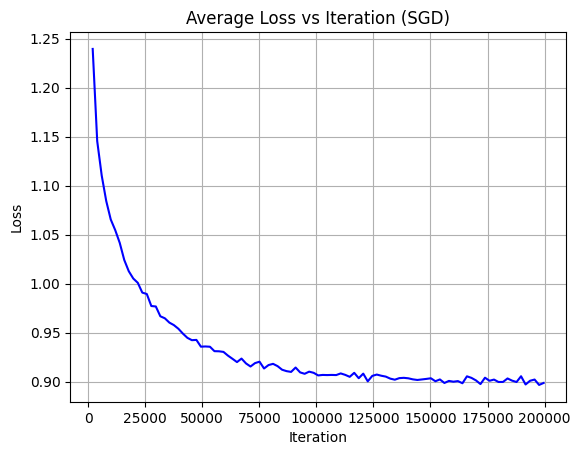

<Figure size 640x480 with 0 Axes>

In [87]:
# initialize parameters randomly
W = 0.01 * np.random.randn(nFeatures,nLabels)
b = np.zeros((1,nLabels))



# Plotting losses
show_plot = True
losses = []
avg_loss_array = []

# some hyperparameters
step_size = 0.01
reg = 1e-3 # regularization strength
batch_size = 30

iterations = 200000
print_freq = round(len(train_df)/batch_size)



# gradient descent loop
for i in range(iterations):

    # This selects "bunch_size" indices ranging from [0, num_samples) whitout replacing
    batch_indices = np.random.choice(num_samples, batch_size, replace=False)



    # Extract the corresponding labels and features
    batch_features = features_array[batch_indices]
    batch_labels = IDs_indeces[batch_indices]

    # evaluate class scores, [N x n_colours]
    scores = np.dot(batch_features, W) + b

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x n_colours]

    # compute the loss: average cross-entropy loss and regularization
    logprobs = -np.log(probs[range(batch_size),batch_labels])
    data_loss = np.sum(logprobs)/batch_size
    reg_loss = 0.5*reg*np.sum(W*W)

    # Early stopping is harder for SGD
    #if(i !=0 ):
    #    if(loss < data_loss + reg_loss):
    #        break
    loss = data_loss + reg_loss

    losses.append(loss)



    if (i % (print_freq) == 0 and i !=0):
        clear_output(wait=True)
        #cumulative_loss = np.cumsum(losses)
        cumulative_loss = np.sum(losses)
        # Calculate the average loss at each iteration
        #avg_loss = cumulative_loss / np.arange(print_freq, i+print_freq +1, print_freq)
        avg_loss = cumulative_loss / print_freq 
        avg_loss_array.append(avg_loss)
        #print("iteration %d: loss %f, avg loss %g" % (i, loss, avg_loss[-1]))
        print("iteration %d: loss %f, avg loss %f" % (i, loss, avg_loss))


        if(show_plot):
            # Plot the losses
            plt.plot(np.arange(print_freq, i+print_freq, print_freq), avg_loss_array, color='blue')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Average Loss vs Iteration (SGD)')
            plt.grid(True)
            display(plt.gcf())  # Display the current figure
            #clear_output(wait=True)  # Clear the output for the next iteration
            #plt.pause(0.01)  # Pause for a short time to update the plot
            plt.clf()  # Clear the current figure for the next iteration
            plt.show()
        #time.sleep(2)
        losses = []

    # compute the gradient on scores
    dscores = probs
    dscores[range(batch_size),batch_labels] -= 1
    dscores /= batch_size

    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(batch_features.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    dW += reg*W # regularization gradient

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db





In [91]:
print(len(train_df)/batch_size)
#print(dscores)
#print(b)
#print(logprobs)
scores = np.dot(features_array, W) + b
predicted_par = np.argmax(scores, axis=1)
print('Training accuracy: %.2f' % (np.mean(predicted_par == IDs_indeces)))
#print_class_accuracy(predicted_par,IDs_indeces)
#print(W)

scores = np.dot(test_features_array, W) + b
predicted_class = np.argmax(scores, axis=1)
print('Test accuracy: %.2f' % (np.mean(predicted_class == test_IDs_indeces)))
print_class_accuracy(predicted_class,test_IDs_indeces)

1976.0
Training accuracy: 0.69
Test accuracy: 0.62
Accuracy for Kaon: 0.63
Accuracy for Pion: 0.49
Accuracy for Positron: 0.81
Accuracy for Proton: 0.79



The training is done, let's now check the performances

In [ ]:
random_particle = np.random.randint(0, len(test_features_array + 1))
print("Extracted row = ", random_particle)
scores = np.dot(test_features_array[random_particle], W) + b
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

print("Probabilities:")
print("- Kaon:     ", f"{probs[0][0]:.3f}")
print("- Pion:     ", f"{probs[0][1]:.3f}")
print("- Positron: ", f"{probs[0][2]:.3f}")
print("- Proton:   ", f"{probs[0][3]:.3f}")
print("Extracted test particle: ",particle_labels[test_IDs_array[random_particle]])

index = np.argmax(scores)
particle_id = next(key for key, value in particleIDs_index.items() if value == index)
print("Predicted Particle: ", particle_labels[particle_id])


Extracted row =  3120
Probabilities:
- Kaon:      0.164
- Pion:      0.066
- Positron:  0.042
- Proton:    0.728
Extracted test particle:  Proton
Predicted Particle:  Proton


# Second Approach: Non linear model using Neural Network.

This NN uses 1 hidden layer with set depth. Again let's see theregular gradient descent first

iteration 14300: loss 0.508002


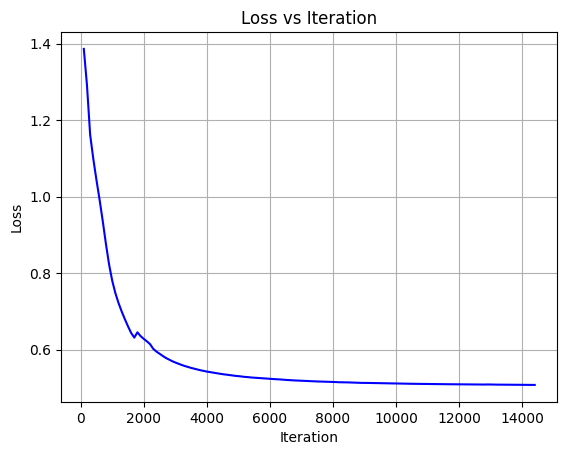

KeyboardInterrupt: 

In [15]:
%matplotlib inline
np.random.seed(39)

h = 100 # size of hidden layer
W = 0.01 * np.random.randn(nFeatures,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,nLabels)
b2 = np.zeros((1,nLabels))


num_samples = features_array.shape[0]


# Plotting losses
show_plot = True
losses = []


iterations = 20000
print_freq = 100

# some hyperparameters for the gradient descent
# Interesting result for step size = 1
step_size = 0.15
reg = 1e-3 # regularization strength

for i in range(iterations):

    # evaluate class scores, [N x n_colours]
    hidden_layer = np.maximum(0, np.dot(features_array, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_samples),IDs_indeces])
    data_loss = np.sum(correct_logprobs)/num_samples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    
    # # implementing early stopping
    # if(i !=0 ):
    #     if(loss < data_loss + reg_loss):
    #         break
    
    loss = data_loss + reg_loss
    if i % print_freq == 0:
        clear_output(wait=True)
        print("iteration %d: loss %f" % (i, loss))

        if(show_plot):
            losses.append(loss)

            plt.clf()  # Clear the current figure for the next iteration
            # Plot the losses
            plt.plot(np.arange(print_freq, i+print_freq+1, print_freq), losses, color='blue')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Loss vs Iteration')
            plt.grid(True)
            #display(plt.gcf())  # Display the current figure
            #clear_output(wait=True)  # Clear the output for the next iteration
            #plt.pause(0.01)  # Pause for a short time to update the plot
            plt.show()


    # compute the gradient on scores
    dscores = probs
    dscores[range(num_samples),IDs_indeces] -= 1
    dscores /= num_samples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(features_array.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

Check accuracy

In [139]:
# evaluate training set accuracy

print(features_array.shape)
print(hidden_layer.shape)

hidden_layer = np.maximum(0, np.dot(features_array, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)

print(accuracy_score(IDs_indeces,predicted_class))
print('Training accuracy: %.2f' % (np.mean(predicted_class == IDs_indeces)))
#print_class_accuracy(predicted_par,IDs_indeces)

hidden_layer = np.maximum(0, np.dot(test_features_array, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
#print(accuracy_score(test_IDs_indeces,predicted_class))
print('Test accuracy: %.2f' % (np.mean(predicted_class == test_IDs_indeces)))
print_class_accuracy(predicted_class,test_IDs_indeces)



(59280, 5)
(9000, 100)
0.9077260458839406
Training accuracy: 0.91
Test accuracy: 0.85
Accuracy for Kaon: 0.97
Accuracy for Pion: 0.76
Accuracy for Positron: 0.89
Accuracy for Proton: 0.97


And training performances

In [ ]:
random_particle = np.random.randint(0, len(test_features_array + 1))
print("Extracted row = ", random_particle)
hidden_layer = np.maximum(0, np.dot(test_features_array[random_particle], W) + b)


scores = np.dot(hidden_layer, W2) + b2
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

print("Probabilities:")
print("- Kaon:     ", f"{probs[0][0]:.3f}")
print("- Pion:     ", f"{probs[0][1]:.3f}")
print("- Positron: ", f"{probs[0][2]:.3f}")
print("- Proton:   ", f"{probs[0][3]:.3f}")
print("Extracted test particle: ",particle_labels[test_IDs_array[random_particle]])

index = np.argmax(scores)
particle_id = next(key for key, value in particleIDs_index.items() if value == index)
print("Predicted Particle: ", particle_labels[particle_id])

Extracted row =  757
Probabilities:
- Kaon:      0.268
- Pion:      0.005
- Positron:  0.000
- Proton:    0.728
Extracted test particle:  Proton
Predicted Particle:  Proton


Now let's see how it compares against the SGD method

iteration 298376: loss 0.961947, avg loss 0.490652


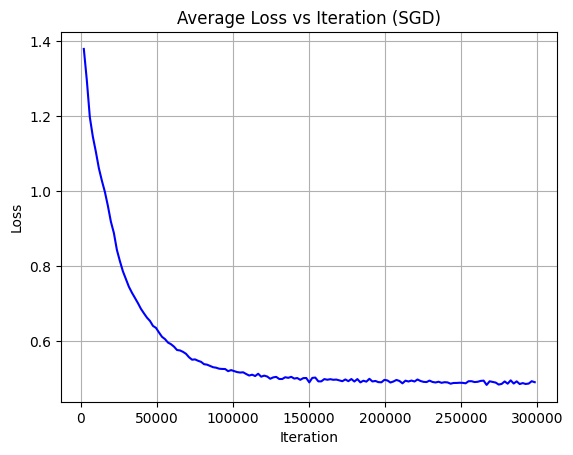

<Figure size 640x480 with 0 Axes>

In [123]:
%matplotlib inline


h = 100 # size of hidden layer
W = 0.01 * np.random.randn(nFeatures,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,nLabels)
b2 = np.zeros((1,nLabels))


num_samples = features_array.shape[0]


# Plotting losses
show_plot = True
losses = []
avg_loss_array = []

iterations = 300000
print_freq = round(len(train_df)/batch_size)

# some hyperparameters for the gradient descent
step_size = 0.005
reg = 1e-3 # regularization strength
batch_size = 30

for i in range(iterations):

    # This selects "bunch_size" indices ranging from [0, num_samples) whitout replacing
    batch_indices = np.random.choice(num_samples, batch_size, replace=False)



    # Extract the corresponding labels and features
    batch_features = features_array[batch_indices]
    batch_labels = IDs_indeces[batch_indices]


    # evaluate class scores, [N x n_colours]
    hidden_layer = np.maximum(0, np.dot(batch_features, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(batch_size),batch_labels])
    data_loss = np.sum(correct_logprobs)/batch_size
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    
    # implementing early stopping
    #if(i !=0 ):
    #    if(loss < data_loss + reg_loss):
    #        break
    

    loss = data_loss + reg_loss
    losses.append(loss)



    if (i % (print_freq) == 0 and i !=0):
        clear_output(wait=True)
        #cumulative_loss = np.cumsum(losses)
        cumulative_loss = np.sum(losses)
        # Calculate the average loss at each iteration
        #avg_loss = cumulative_loss / np.arange(print_freq, i+print_freq +1, print_freq)
        avg_loss = cumulative_loss / print_freq 
        avg_loss_array.append(avg_loss)
        #print("iteration %d: loss %f, avg loss %g" % (i, loss, avg_loss[-1]))
        print("iteration %d: loss %f, avg loss %f" % (i, loss, avg_loss))


        if(show_plot):
            # Plot the losses
            plt.plot(np.arange(print_freq, i+print_freq, print_freq), avg_loss_array, color='blue')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Average Loss vs Iteration (SGD)')
            plt.grid(True)
            display(plt.gcf())  # Display the current figure
            #clear_output(wait=True)  # Clear the output for the next iteration
            #plt.pause(0.01)  # Pause for a short time to update the plot
            plt.clf()  # Clear the current figure for the next iteration
            plt.show()
        #time.sleep(2)
        losses = []
            


    # compute the gradient on scores
    dscores = probs
    dscores[range(batch_size),batch_labels] -= 1
    dscores /= batch_size

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(batch_features.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2




In [133]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(features_array, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('Training accuracy: %.2f' % (np.mean(predicted_class == IDs_indeces)))
#print_class_accuracy(predicted_class,IDs_indeces)


hidden_layer = np.maximum(0, np.dot(test_features_array, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('Test accuracy: %.2f' % (np.mean(predicted_class == test_IDs_indeces)))
print_class_accuracy(predicted_class,test_IDs_indeces)


Training accuracy: 0.91
Test accuracy: 0.85
Accuracy for Kaon: 0.97
Accuracy for Pion: 0.76
Accuracy for Positron: 0.89
Accuracy for Proton: 0.97


In [130]:
random_particle = np.random.randint(0, len(test_features_array + 1))
print("Extracted row = ", random_particle)
hidden_layer = np.maximum(0, np.dot(test_features_array[random_particle], W) + b)

scores = np.dot(hidden_layer, W2) + b2
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

print("Probabilities:")
print("- Kaon:     ", f"{probs[0][0]:.3f}")
print("- Pion:     ", f"{probs[0][1]:.3f}")
print("- Positron: ", f"{probs[0][2]:.3f}")
print("- Proton:   ", f"{probs[0][3]:.3f}")
print("Extracted test particle: ",particle_labels[test_IDs_array[random_particle]])
index = np.argmax(scores)
particle_id = next(key for key, value in particleIDs_index.items() if value == index)
print("Predicted Particle: ", particle_labels[particle_id])


Extracted row =  5323
Probabilities:
- Kaon:      0.208
- Pion:      0.763
- Positron:  0.029
- Proton:    0.000
Extracted test particle:  Pion
Predicted Particle:  Pion


# Finally we validate performances using sklearn implementations

Linear model without SGD

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Instantiate the model
model = LogisticRegression(class_weight='balanced', multi_class='ovr', verbose = 0)
model = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', verbose=1)


# Fit the model



model.fit(features_array, IDs_array)




# Predict with the model
y_pred = model.predict(features_array)

# Calculate the scores for each class
scores = model.predict_proba(features_array)

# Evaluate the model (e.g., using accuracy)
accuracy = accuracy_score(IDs_array, y_pred)

print(f"Training accuracy: {accuracy:.2f}")

# Predict with the model
y_pred = model.predict(test_features_array)

# Calculate the scores for each class
scores = model.predict_proba(test_features_array)

# Evaluate the model (e.g., using accuracy)
accuracy = accuracy_score(test_IDs_array, y_pred)

print(f"Test accuracy: {accuracy:.2f}")

class_accuracy = {}
sorted_id = [2, 1, 0, 3]
for class_idx in sorted_id:
    class_name = model.classes_[class_idx]
    class_indices = test_IDs_array == class_name
    class_accuracy[class_name] = accuracy_score(test_IDs_array[class_indices], y_pred[class_indices])

# Print the accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Accuracy for {particle_labels[class_name]}: {accuracy:.2f}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38629D+00    |proj g|=  1.52286D-01


 This problem is unconstrained.



At iterate   50    f=  6.24272D-01    |proj g|=  9.15625D-03

At iterate  100    f=  5.82278D-01    |proj g|=  5.34992D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24    100    107      1     0     0   5.350D-03   5.823D-01
  F =  0.58227750947028767     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Training accuracy: 0.83
Test accuracy: 0.79
Accuracy for Kaon: 0.79
Accuracy for Pion: 0.76
Accuracy for Positron: 0.85
Accuracy for Proton: 0.84


/home/davide/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Adding stochasticity

In [116]:
from sklearn.linear_model import SGDClassifier




# Instantiate the model with SGD
sgd_model = SGDClassifier(loss='log_loss', verbose=1)

# Fit the model
sgd_model.fit(features_array, IDs_array)




# Predict with the model
sgd_y_pred = sgd_model.predict(features_array)

# Evaluate the model (e.g., using accuracy)
sgd_accuracy = accuracy_score(IDs_array, sgd_y_pred)

#print("Accuracy (Logistic Regression with SGD):", sgd_accuracy)

print(f"Training accuracy: {sgd_accuracy:.2f}")




# Predict with the model
sgd_y_pred = sgd_model.predict(test_features_array)

# Evaluate the model (e.g., using accuracy)
sgd_accuracy = accuracy_score(test_IDs_array, sgd_y_pred)

#print("Accuracy (Logistic Regression with SGD):", sgd_accuracy)

print(f"Test accuracy: {sgd_accuracy:.2f}")

class_accuracy = {}
sorted_id = [2, 1, 0, 3]
for class_idx in sorted_id:
    class_name = model.classes_[class_idx]
    class_indices = test_IDs_array == class_name
    class_accuracy[class_name] = accuracy_score(test_IDs_array[class_indices], sgd_y_pred[class_indices])

# Print the accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Accuracy for {particle_labels[class_name]}: {sgd_accuracy:.2f}")

-- Epoch 1
Norm: 27.62, NNZs: 5, Bias: -18.985597, T: 59280, Avg. loss: 0.244199
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 27.00, NNZs: 5, Bias: -17.977528, T: 118560, Avg. loss: 0.184851
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 26.53, NNZs: 5, Bias: -18.010142, T: 177840, Avg. loss: 0.183866
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 26.53, NNZs: 5, Bias: -17.816163, T: 237120, Avg. loss: 0.183426
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 26.32, NNZs: 5, Bias: -17.856228, T: 296400, Avg. loss: 0.182962
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 26.25, NNZs: 5, Bias: -17.837180, T: 355680, Avg. loss: 0.183060
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 26.29, NNZs: 5, Bias: -17.722468, T: 414960, Avg. loss: 0.183109
Total training time: 0.12 seconds.
Convergence after 7 epochs took 0.12 seconds
-- Epoch 1
Norm: 9.64, NNZs: 5, Bias: -10.827543, T: 59280, Avg. loss: 0.732248
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 9.63,

Now trying neural network


In [134]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(hidden_layer_sizes=(100,), batch_size=30, verbose=1)

# Fit the model
nn_model.fit(features_array, IDs_array)

# Predict with the model
nn_y_pred = nn_model.predict(features_array)

# Evaluate the model (e.g., using accuracy)
nn_accuracy = accuracy_score(IDs_array, nn_y_pred)

print(f"Training accuracy: {nn_accuracy:.2f}")



# Predict with the model
nn_y_pred = nn_model.predict(test_features_array)

# Evaluate the model (e.g., using accuracy)
nn_accuracy = accuracy_score(test_IDs_array, nn_y_pred)

print(f"Test accuracy: {nn_accuracy:.2f}")

class_accuracy = {}
sorted_id = [2, 1, 0, 3]
for class_idx in sorted_id:
    class_name = model.classes_[class_idx]
    class_indices = test_IDs_array == class_name
    class_accuracy[class_name] = accuracy_score(test_IDs_array[class_indices], y_pred[class_indices])

# Print the accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Accuracy for {particle_labels[class_name]}: {nn_accuracy:.2f}")

Iteration 1, loss = 0.85568648
Iteration 2, loss = 0.56053727
Iteration 3, loss = 0.46047236
Iteration 4, loss = 0.40761687
Iteration 5, loss = 0.37479594
Iteration 6, loss = 0.34973445
Iteration 7, loss = 0.33225522
Iteration 8, loss = 0.31920578
Iteration 9, loss = 0.30957827
Iteration 10, loss = 0.30207638
Iteration 11, loss = 0.29642003
Iteration 12, loss = 0.29089885
Iteration 13, loss = 0.28745947
Iteration 14, loss = 0.28323144
Iteration 15, loss = 0.28075878
Iteration 16, loss = 0.27847864
Iteration 17, loss = 0.27538535
Iteration 18, loss = 0.27245093
Iteration 19, loss = 0.27130526
Iteration 20, loss = 0.26847952
Training accuracy: 0.92
Test accuracy: 0.90
Accuracy for Kaon: 0.90
Accuracy for Pion: 0.90
Accuracy for Positron: 0.90
Accuracy for Proton: 0.90


/home/davide/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Finally nn with stochasticity

In [135]:
# Instantiate the model with a single hidden layer and SGD
nn_sgd_model = MLPClassifier(hidden_layer_sizes=(100,), solver='sgd', batch_size=30, verbose=1, max_iter=500)

# Fit the model
nn_sgd_model.fit(features_array, IDs_array)


# Predict with the model
nn_sgd_y_pred = nn_sgd_model.predict(features_array)

# Evaluate the model (e.g., using accuracy)
nn_sgd_accuracy = accuracy_score(IDs_array, nn_sgd_y_pred)

print(f"Test accuracy: {nn_sgd_accuracy:.2f}")


# Predict with the model
nn_sgd_y_pred = nn_sgd_model.predict(test_features_array)

# Evaluate the model (e.g., using accuracy)
nn_sgd_accuracy = accuracy_score(test_IDs_array, nn_sgd_y_pred)

print(f"Test accuracy: {nn_sgd_accuracy:.2f}")

class_accuracy = {}
sorted_id = [2, 1, 0, 3]
for class_idx in sorted_id:
    class_name = model.classes_[class_idx]
    class_indices = test_IDs_array == class_name
    class_accuracy[class_name] = accuracy_score(test_IDs_array[class_indices], y_pred[class_indices])

# Print the accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Accuracy for {particle_labels[class_name]}: {nn_sgd_accuracy:.2f}")

Iteration 1, loss = 1.15135614
Iteration 2, loss = 0.98792192
Iteration 3, loss = 0.88214363
Iteration 4, loss = 0.79639692
Iteration 5, loss = 0.73014286
Iteration 6, loss = 0.67772647
Iteration 7, loss = 0.63415053
Iteration 8, loss = 0.59678692
Iteration 9, loss = 0.56448844
Iteration 10, loss = 0.53684536
Iteration 11, loss = 0.51289700
Iteration 12, loss = 0.49215417
Iteration 13, loss = 0.47438340
Iteration 14, loss = 0.45896979
Iteration 15, loss = 0.44593622
Iteration 16, loss = 0.43419895
Iteration 17, loss = 0.42361437
Iteration 18, loss = 0.41448047
Iteration 19, loss = 0.40636043
Iteration 20, loss = 0.39875125
Iteration 21, loss = 0.39233281
Iteration 22, loss = 0.38639336
Iteration 23, loss = 0.38092315
Iteration 24, loss = 0.37625800
Iteration 25, loss = 0.37164949
Iteration 26, loss = 0.36755934
Iteration 27, loss = 0.36412385
Iteration 28, loss = 0.36063132
Iteration 29, loss = 0.35750611
Iteration 30, loss = 0.35463094
Iteration 31, loss = 0.35181947
Iteration 32, los

/home/davide/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
